Reading time series (MintPy)...
Attempting to get lon/lat of pixel centers...
Reading masks...
Loading polygons from GeoJSON: /insar-data/PinheirosSP/miaplpy/PinheirosSP.geojson
Building pixel-center points GeoDataFrame…
Selecting pixels and averaging time series per polygon…
  S1: 18 pixels — avg TC=0.544
  S2: 15 pixels — avg TC=0.671
  S3: 16 pixels — avg TC=0.444
  S4: 16 pixels — avg TC=0.544
  S5: 17 pixels — avg TC=0.335
  S6: 9 pixels — avg TC=0.573
  S7: 17 pixels — avg TC=0.570
  S8: 19 pixels — avg TC=0.622
  S9: 18 pixels — avg TC=0.558
  S10: 14 pixels — avg TC=0.415
  S11: 20 pixels — avg TC=0.418
Plotting…


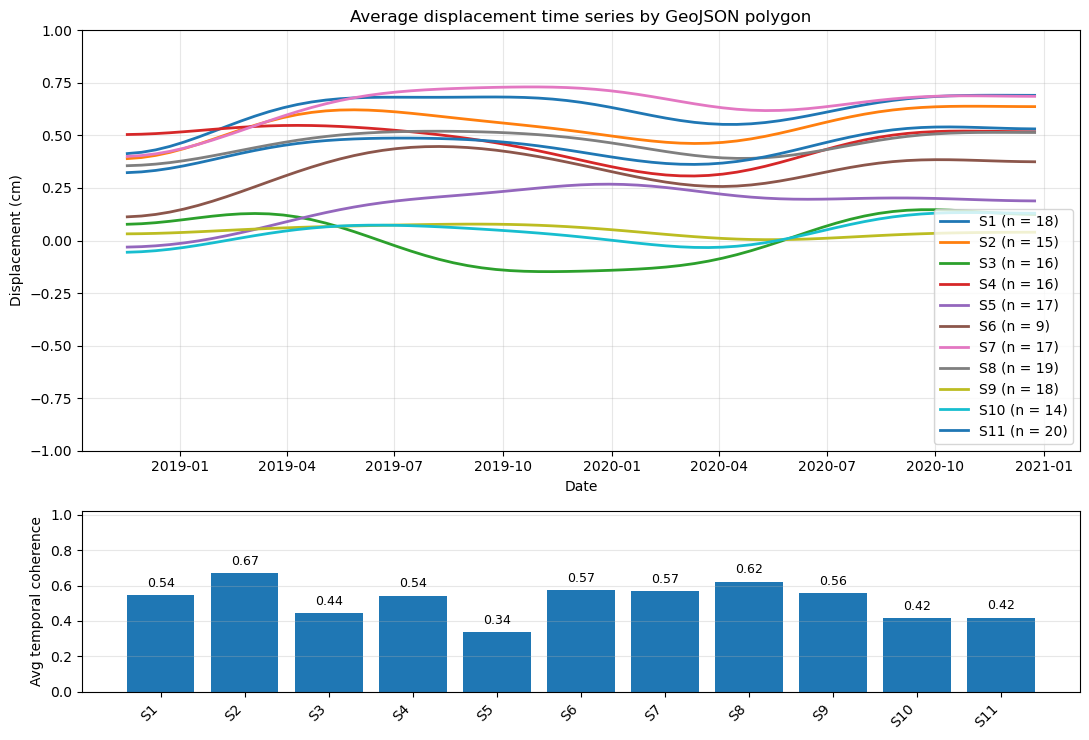

Done.


In [13]:
# -*- coding: utf-8 -*-
"""
Average PS time series inside GeoJSON polygons (MintPy-friendly I/O)
+ Average temporal coherence per polygon (bar chart)

Dependencies:
    pip install mintpy h5py numpy pandas geopandas shapely matplotlib

Notes:
- Uses mintpy.utils.readfile.read() for all MintPy files (timeseries, tc, mask).
- For polygon selection, needs lon/lat of pixel centers:
    * First tries to read from geometry*.h5 (longitude/latitude).
    * If not found, reconstructs lon/lat by bilinear interpolation from
      lat_ref1..4 / lon_ref1..4 attributes in the timeseries file.
"""
import h5py
from pathlib import Path
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from mintpy.utils import readfile

# ----------------- USER SETTINGS -----------------
TS_PATH   = Path("/insar-data/PinheirosSP/miaplpyafter/network_delaunay_4/timeseries_ERA5_demErr.h5")
TC_PATH   = Path("/insar-data/PinheirosSP/miaplpyafter/network_delaunay_4/temporalCoherence.h5")
MASK_PS   = Path("/insar-data/PinheirosSP/miaplpyafter/maskPS.h5")

# If you have a MintPy geometry file with lon/lat, you may point to it here (optional).
# If left as None, the script will auto-try common names next to TS_PATH, else fall back to corner refs.
GEOMETRY_PATH = "/insar-data/PinheirosSP/miaplpyafter/network_delaunay_4/inputs/geometryRadar.h5"  # e.g., Path("/insar-data/.../geometryGeo.h5") or geometryRadar.h5

# GeoJSON with your polygons (WGS84 lon/lat)
POLYGONS_GEOJSON = Path("/insar-data/PinheirosSP/miaplpy/PinheirosSP.geojson")
POLYGON_NAME_FIELD = "Name"   # (optional) attribute in GeoJSON to use as series label, else "poly_<i>"

COH_THR = None   # set to None to disable temporal coherence filtering
UNITS   = "cm"   # "m" or "mm"

SAVE_FIG = None   # set to None to skip
SAVE_CSV = None  # set to None to skip
LINEWIDTH = 2.0
# -------------------------------------------------


# ----------------- HELPERS -----------------
def read_ts_mintpy(ts_path: Path):
    """
    Robust time-series reader:
      1) Read data with MintPy (ts3d: (T,R,C), atr).
      2) Read '/date' directly via h5py and parse strictly as YYYYMMDD.
      3) If '/date' missing, fall back to DATE_LIST / DATE_TIMES attrs.
      4) Validate count vs T and sort time axis if needed.
    Returns:
      ts3d (T,R,C) float32, dates (DatetimeIndex), atr (dict)
    """
    # 1) MintPy read for the data/attrs
    ts3d, atr = readfile.read(str(ts_path))           # typically (T, R, C)
    T = int(ts3d.shape[0])

    # 2) Try h5py on '/date' (source of truth per your info.py)
    dates = None
    with h5py.File(str(ts_path), "r") as f:
        if "date" in f:
            raw = f["date"][()]              # shape (T,), dtype likely '|S8'
        elif "/date" in f:                    # just in case
            raw = f["/date"][()]
        else:
            raw = None

    if raw is not None:
        arr = np.asarray(raw).ravel()
        # bytes -> str
        if arr.dtype.kind == "S":
            strs = [b.decode("ascii", "ignore").strip() for b in arr]
        else:
            # sometimes stored as numeric; force 'YYYYMMDD'
            strs = [f"{int(x):08d}" if isinstance(x, (np.integer, int)) else str(x).strip() for x in arr]

        # Prefer exact YYYYMMDD; if that fails, try generic then normalize
        try:
            if all(len(s) == 8 and s.isdigit() for s in strs):
                dates = pd.to_datetime(strs, format="%Y%m%d", errors="raise")
            else:
                # try generic then normalize to YYYYMMDD if needed
                try:
                    dates = pd.to_datetime(strs, errors="raise")
                except Exception:
                    norm = [s.replace("-", "").replace("/", "") for s in strs]
                    dates = pd.to_datetime(norm, format="%Y%m%d", errors="raise")
        except Exception:
            dates = None

    # 3) Fallback to MintPy attributes if '/date' was absent or unreadable
    if dates is None:
        if "DATE_LIST" in atr and atr["DATE_LIST"]:
            dates = pd.to_datetime(atr["DATE_LIST"].split(), format="%Y%m%d", errors="raise")
        elif "DATE_TIMES" in atr and atr["DATE_TIMES"]:
            dates = pd.to_datetime(atr["DATE_TIMES"].split(), errors="raise")
        else:
            raise ValueError(
                "Could not read '/date' and no DATE_LIST / DATE_TIMES in attributes. "
                "Run `info.py` to confirm datasets."
            )

    # 4) Validate length and sort time axis if necessary
    if len(dates) != T:
        raise ValueError(f"Dates length {len(dates)} != T {T} in {ts_path}")

    order = np.argsort(dates.values)
    if not np.all(order == np.arange(T)):
        ts3d = ts3d[order, ...]
        dates = dates[order]

    return ts3d.astype(np.float32), pd.DatetimeIndex(dates), atr


def read_2d_mintpy(path: Path, candidates=("/mask", "/temporalCoherence", "temporalCoherence", "mask")):
    """Read a 2D dataset via MintPy readfile with name guessing."""
    # try default
    try:
        arr, _ = readfile.read(str(path))
        if arr.ndim == 2:
            return arr
    except Exception:
        pass
    # try candidates
    for name in candidates:
        try:
            arr, _ = readfile.read(str(path), datasetName=name)
            if arr.ndim == 2:
                return arr
        except Exception:
            continue
    raise RuntimeError(f"Could not read a 2D dataset from {path}")


def try_read_lonlat_from_geometry(geom_path: Path):
    """Try to read longitude/latitude (2D) from a MintPy geometry*.h5 file."""
    if geom_path is None or not Path(geom_path).exists():
        return None, None
    # common dataset names
    lon_candidates = ("longitude", "/longitude", "lon", "/lon")
    lat_candidates = ("latitude", "/latitude", "lat", "/lat")
    lon = lat = None
    for name in lon_candidates:
        try:
            lon, _ = readfile.read(str(geom_path), datasetName=name)
            break
        except Exception:
            continue
    for name in lat_candidates:
        try:
            lat, _ = readfile.read(str(geom_path), datasetName=name)
            break
        except Exception:
            continue
    if lon is not None and lat is not None and lon.ndim == 2 and lat.ndim == 2:
        return np.array(lon, dtype=np.float64), np.array(lat, dtype=np.float64)
    return None, None


def lonlat_from_corner_refs(ts_path: Path, T_R_C_shape):
    """
    Reconstruct lon/lat (R,C) by bilinear interpolation from lat_ref1..4 / lon_ref1..4.
    Chooses the most consistent corner assignment automatically.
    """
    _, R, C = T_R_C_shape
    # Read attrs with MintPy readfile (to get attrs consistently)
    _, atr = readfile.read(str(ts_path))  # we only need attrs here
    # Normalize keys to lowercase for convenience
    attrs = {k.lower(): v for k, v in atr.items()}
    try:
        lats = [float(attrs[f'lat_ref{i}']) for i in range(1, 5)]
        lons = [float(attrs[f'lon_ref{i}']) for i in range(1, 5)]
    except Exception as e:
        raise RuntimeError("lat_ref*/lon_ref* not found in timeseries attributes; "
                           "cannot reconstruct lon/lat without geometry*.h5") from e

    v = np.linspace(0.0, 1.0, R)[:, None]  # rows
    u = np.linspace(0.0, 1.0, C)[None, :]  # cols

    def bilinear(c00, c10, c01, c11):
        return ((1 - u) * (1 - v) * c00 +
                u * (1 - v) * c10 +
                (1 - u) * v * c01 +
                u * v * c11)

    def score_grid(LON, LAT):
        dlon_x = np.nanmedian(np.diff(LON, axis=1))
        dlat_y = np.nanmedian(np.diff(LAT, axis=0))
        flips_x = int(np.sum(np.sign(np.diff(LON, axis=1)) != np.sign(dlon_x)))
        flips_y = int(np.sum(np.sign(np.diff(LAT, axis=0)) != np.sign(dlat_y)))
        dlon_dy = np.nanmedian(np.diff(LON, axis=0))
        dlat_dx = np.nanmedian(np.diff(LAT, axis=1))
        det_sign = np.sign(dlon_x * dlat_y - dlon_dy * dlat_dx)
        return (flips_x + flips_y) + (0 if det_sign != 0 else 1000), abs(dlon_x) + abs(dlat_y)

    best = None
    corners = list(zip(lons, lats))  # (lon, lat)
    for perm in itertools.permutations(corners, 4):
        (lon00, lat00), (lon10, lat10), (lon01, lat01), (lon11, lat11) = perm
        LON = bilinear(lon00, lon10, lon01, lon11)
        LAT = bilinear(lat00, lat10, lat01, lat11)

        lon_ok = (min(lons) - 1.0) <= float(np.nanmin(LON)) <= float(np.nanmax(LON)) <= (max(lons) + 1.0)
        lat_ok = (min(lats) - 1.0) <= float(np.nanmin(LAT)) <= float(np.nanmax(LAT)) <= (max(lats) + 1.0)
        if not (lon_ok and lat_ok):
            continue

        score = score_grid(LON, LAT)
        if (best is None) or (score < best[0]):
            best = (score, (LON, LAT))

    if best is None:
        raise RuntimeError("Failed to pick a consistent corner assignment for lon/lat.")
    return best[1]


def load_polygons_geojson(path: Path):
    """Load polygons from GeoJSON (ensure EPSG:4326)."""
    gdf = gpd.read_file(path)
    if gdf.crs is None:
        gdf = gdf.set_crs(epsg=4326)
    else:
        gdf = gdf.to_crs(epsg=4326)
    gdf = gdf[gdf.geometry.notna()].copy()
    gdf = gdf[gdf.geometry.geom_type.isin(["Polygon", "MultiPolygon"])].copy()
    gdf.reset_index(drop=True, inplace=True)
    return gdf


def rolling_median(x, win):
    """Rolling median with edge handling (centered window; uses nanmedian)."""
    x = np.asarray(x, dtype=float)
    n = x.size
    half = win // 2
    rm = np.full(n, np.nan)
    for i in range(n):
        i0 = max(0, i - half)
        i1 = min(n, i + half + 1)
        rm[i] = np.nanmedian(x[i0:i1])
    return rm


def apply_smoothing_filter(series, window=5, method='gaussian'):
    """
    Apply smoothing filter to make time series smoother.
    
    Parameters:
    - series: input time series (1D array)
    - window: window size for smoothing
    - method: smoothing method ('moving_avg', 'gaussian', 'savgol')
    
    Returns:
    - smoothed_series: smoothed time series
    """
    from scipy import ndimage
    from scipy.signal import savgol_filter
    
    series = np.array(series, dtype=float)
    
    if method == 'moving_avg':
        # Simple moving average
        return rolling_median(series, window)  # Reuse existing rolling function but with mean
    
    elif method == 'gaussian':
        # Gaussian smoothing - good for preserving overall trends while reducing noise
        sigma = window / 3.0  # Standard deviation for Gaussian kernel
        # Handle NaN values
        mask = ~np.isnan(series)
        if np.any(mask):
            smoothed = series.copy()
            smoothed[mask] = ndimage.gaussian_filter1d(series[mask], sigma=sigma)
            return smoothed
        else:
            return series
    
    elif method == 'savgol':
        # Savitzky-Golay filter - good for preserving peaks while smoothing
        if len(series) > window and window >= 3:
            # Handle NaN values by interpolating first
            mask = ~np.isnan(series)
            if np.sum(mask) > window:
                from scipy.interpolate import interp1d
                valid_indices = np.where(mask)[0]
                if len(valid_indices) > 2:
                    f = interp1d(valid_indices, series[valid_indices], 
                               kind='linear', fill_value='extrapolate')
                    series_interp = f(np.arange(len(series)))
                    return savgol_filter(series_interp, window, polyorder=2)
        return series
    
    return series


# ----------------- MAIN -----------------
def main():
    print("Reading time series (MintPy)...")
    ts3d, dates, atr = read_ts_mintpy(TS_PATH)  # (T, R, C)
    T, R, C = ts3d.shape
    ts_flat = np.moveaxis(ts3d, 0, -1).reshape(R*C, T)

    print("Attempting to get lon/lat of pixel centers...")
    # 1) Try geometry file (explicit or auto)
    geom_path = GEOMETRY_PATH 
    lon2d, lat2d = try_read_lonlat_from_geometry(geom_path) if geom_path else (None, None)

    # 2) Fall back to corner refs
    if lon2d is None or lat2d is None:
        print("  geometry*.h5 not found or missing lon/lat; reconstructing from corner refs...")
        lon2d, lat2d = lonlat_from_corner_refs(TS_PATH, ts3d.shape)  # (R, C)

    lon = lon2d.ravel()
    lat = lat2d.ravel()

    print("Reading masks...")
    ps_mask = read_2d_mintpy(MASK_PS, candidates=("/mask", "mask")).astype(bool)     # (R, C)
    tc      = read_2d_mintpy(TC_PATH, candidates=("/temporalCoherence","temporalCoherence")).astype(np.float32)  # (R, C)
    if ps_mask.shape != (R, C) or tc.shape != (R, C):
        raise ValueError(f"Mask/TC shape mismatch: mask {ps_mask.shape}, tc {tc.shape}, data {(R,C)}")

    keep = ps_mask.copy()
    if COH_THR is not None:
        keep &= (tc >= COH_THR)
    keep_flat = keep.ravel()

    print(f"Loading polygons from GeoJSON: {POLYGONS_GEOJSON}")
    gdf_poly = load_polygons_geojson(POLYGONS_GEOJSON)

    # Build points geodataframe (pixel centers)
    print("Building pixel-center points GeoDataFrame…")
    points = gpd.GeoDataFrame(
        {"idx": np.arange(lon.size, dtype=np.int64)},
        geometry=gpd.points_from_xy(lon, lat),
        crs="EPSG:4326",
    )

    # Units
    yscale = 1.0 if UNITS == "m" else (1000.0 if UNITS == "mm" else 100.0 if UNITS == "cm" else 1.0)
    yunit  = "mm" if UNITS == "mm" else "cm" if UNITS == "cm" else "m"

    # For each polygon: select + average
    labels, curves, counts, tcs = [], [], [], []

    print("Selecting pixels and averaging time series per polygon…")
    if gdf_poly.crs != points.crs:
        gdf_poly = gdf_poly.to_crs(points.crs)

    for i, row in gdf_poly.iterrows():
        geom = row.geometry
        if geom is None:
            continue
        inside = points.within(geom).values  # (N,)
        sel = inside  # use inside & keep_flat if you want to enforce PS/TC filtering

        n = int(sel.sum())
        if n == 0:
            print(f"  polygon {i}: 0 pixels (after mask/TC); skipping.")
            continue

        avg_ts = np.nanmean(ts_flat[sel, :], axis=0) * yscale
        avg_tc = float(np.nanmean(tc.ravel()[sel]))

        name = str(row[POLYGON_NAME_FIELD]) if POLYGON_NAME_FIELD and POLYGON_NAME_FIELD in gdf_poly.columns else f"poly_{i}"
        labels.append(name)
        curves.append(avg_ts)
        counts.append(n)
        tcs.append(avg_tc)
        print(f"  {name}: {n} pixels — avg TC={avg_tc:.3f}")

    if not curves:
        raise RuntimeError("No pixels selected for any polygon. Check CRS, geometry, or thresholds.")

    # Plot
    print("Plotting…")
    fig, (ax_ts, ax_tc) = plt.subplots(
        2, 1, figsize=(11, 7.5),
        gridspec_kw={'height_ratios': [2.8, 1.2]}
    )

    # Top: time series (with smoothing)
    for lab, y, counts in zip(labels, curves, counts):
        y_smooth = apply_smoothing_filter(y, window=21, method='gaussian')
        ax_ts.plot(dates, y_smooth, label=f"{lab} (n = {counts})", linewidth=LINEWIDTH)

    ax_ts.set_xlabel("Date")
    ax_ts.set_ylabel(f"Displacement ({yunit})")
    ax_ts.set_title("Average displacement time series by GeoJSON polygon")
    ax_ts.set_ylim(-1, 1)
    ax_ts.grid(True, alpha=0.3)
    ax_ts.legend()

    # Bottom: average temporal coherence per polygon
    x = np.arange(len(labels))
    bars = ax_tc.bar(x, tcs)
    ax_tc.set_ylabel("Avg temporal coherence")
    ax_tc.set_ylim(0, 1.02)
    ax_tc.grid(True, axis='y', alpha=0.3)
    ax_tc.set_xticks(x)
    ax_tc.set_xticklabels(labels, rotation=45, ha='right')

    # Annotate bar tops with values
    for i, v in enumerate(tcs):
        ax_tc.text(i, min(v + 0.03, 1.02), f"{v:.2f}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    if SAVE_FIG:
        plt.savefig(SAVE_FIG, dpi=200)
        print(f"Saved figure: {SAVE_FIG}")
    plt.show()

    # CSV
    if SAVE_CSV:
        out = pd.DataFrame({"date": pd.to_datetime(dates)})
        for lab, y in zip(labels, curves):
            out[lab] = y
        # also append the per-polygon average TC as a single-row footer-style record (optional)
        # Create a small table with avg TC for reference
        tc_table = pd.DataFrame({"polygon": labels, "avg_temporal_coherence": tcs, "pixel_count": counts})
        # Save both: time series and a separate _tc.csv for clarity
        out.to_csv(SAVE_CSV, index=False)
        tc_csv = SAVE_CSV.with_name(SAVE_CSV.stem + "_tc.csv")
        tc_table.to_csv(tc_csv, index=False)
        print(f"Saved CSV: {SAVE_CSV}")
        print(f"Saved TC CSV: {tc_csv}")

    print("Done.")


if __name__ == "__main__":
    main()
